In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, KFold

import matplotlib.pyplot as plt

In [2]:
glogs_final = pd.read_csv('https://raw.githubusercontent.com/tmarchok1/DS440_project/refs/heads/main/glogs_final.csv')
glogs_final

,date,year,week,day_of_week,v_name,h_name,day_night,park_id,temp,precip,capacity,prev_year_wins,made_playoffs,won_division,InstagramFollowers,CityPopulation,attendance
0,2005-04-03,2005,1,Sun,BOS,NYY,1,Old Yankee Stadium,51.7,0.587,56937.0,101,1,1,3900000,19940274,54818.0
1,2005-04-04,2005,1,Mon,OAK,BAL,0,Camden Yards,60.7,0.000,45971.0,78,0,0,746000,2859024,48271.0
2,2005-04-04,2005,1,Mon,CLE,CHW,0,US Cellular Field,56.2,0.000,40615.0,83,0,0,664000,9408576,38141.0
3,2005-04-04,2005,1,Mon,KC,DET,0,Comerica Park,59.0,0.000,41083.0,72,0,0,1000000,4400587,44105.0
4,2005-04-04,2005,1,Mon,MIN,SEA,0,Safeco Field,50.1,0.130,47943.0,63,0,0,927000,4145494,46249.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29030,2016-10-02,2016,24,Sun,MIL,COL,0,Coors Field,78.8,0.000,50144.0,68,0,0,552000,3052498,27762.0
29031,2016-10-02,2016,24,Sun,NYM,PHI,0,Citizens Bank Park,70.5,0.039,43651.0,63,0,0,1300000,6330422,36935.0
29032,2016-10-02,2016,24,Sun,LAD,SF,0,AT&T Park,66.0,0.000,41915.0,84,0,0,1600000,4648486,41445.0
29033,2016-10-02,2016,24,Sun,PIT,STL,0,Busch Stadium III,69.3,0.028,45494.0,100,1,1,1100000,2811927,44615.0


In [3]:
# # Create dummy model using only h_name variable
# homedf = glogs_final.groupby('h_name')['attendance'].mean().sort_values().to_frame()
# dummydf = pd.merge(glogs_final, homedf, on='h_name', how='left')
# dummydf

# # Evaluation metrics for dummy model
# mse = mean_squared_error(dummydf['attendance_x'], dummydf['attendance_y'])
# rmse = mse**(1/2)
# r2 = r2_score(dummydf['attendance_x'], dummydf['attendance_y'])

# print(f'Mean Squared Error (MSE): {mse:.2f}')
# print(f'RMSE: {rmse:.2f}')
# print(f'R-squared Score (R²): {r2:.2f}')

In [4]:
# Data preprocessing

# Drop columns
glogs_final = glogs_final.drop(columns=['date', 'year', 'temp'])

# Binary encode 'day_of_week' and 'precip'
glogs_final['day_of_week'] = glogs_final['day_of_week'].map({'Mon':0, 'Tue':0, 'Wed':0, 'Thu':0, 'Fri':1, 'Sat':1, 'Sun':1}).astype('int')
glogs_final['precip'] = glogs_final['precip'].map(lambda x: 1 if x != 0 else 0)
glogs_final

# Apply OneHotEncoder to 'v_name', 'h_name', 'park_id' columns
encoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False), ['week', 'v_name', 'h_name', 'park_id'])],
    remainder='passthrough'  # Keep other columns if there are any
)

df_encoded = encoder.fit_transform(glogs_final)

# Rename columns
feature_names = encoder.get_feature_names_out()
feature_names = [name.replace("remainder__", "") for name in feature_names]

# Convert the result back to a DataFrame (optional)
df_encoded = pd.DataFrame(df_encoded, columns=feature_names)
df_encoded

,cat__week_1,cat__week_2,cat__week_3,cat__week_4,cat__week_5,cat__week_6,cat__week_7,cat__week_8,cat__week_9,cat__week_10,...,day_of_week,day_night,precip,capacity,prev_year_wins,made_playoffs,won_division,InstagramFollowers,CityPopulation,attendance
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,56937.0,101.0,1.0,1.0,3900000.0,19940274.0,54818.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45971.0,78.0,0.0,0.0,746000.0,2859024.0,48271.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,40615.0,83.0,0.0,0.0,664000.0,9408576.0,38141.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,41083.0,72.0,0.0,0.0,1000000.0,4400587.0,44105.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,47943.0,63.0,0.0,0.0,927000.0,4145494.0,46249.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,50144.0,68.0,0.0,0.0,552000.0,3052498.0,27762.0
29031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,43651.0,63.0,0.0,0.0,1300000.0,6330422.0,36935.0
29032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,41915.0,84.0,0.0,0.0,1600000.0,4648486.0,41445.0
29033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,45494.0,100.0,1.0,1.0,1100000.0,2811927.0,44615.0


In [5]:
df_encoded #model ready dataset
#24 weeks + 60 visitor/home + 36 park ID + day of week + dayNight + precip + capacity + prev yr wins 
#+ made playoffs + won division + IG Followers + City population + attendance = 130 variables 

,cat__week_1,cat__week_2,cat__week_3,cat__week_4,cat__week_5,cat__week_6,cat__week_7,cat__week_8,cat__week_9,cat__week_10,...,day_of_week,day_night,precip,capacity,prev_year_wins,made_playoffs,won_division,InstagramFollowers,CityPopulation,attendance
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,56937.0,101.0,1.0,1.0,3900000.0,19940274.0,54818.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45971.0,78.0,0.0,0.0,746000.0,2859024.0,48271.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,40615.0,83.0,0.0,0.0,664000.0,9408576.0,38141.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,41083.0,72.0,0.0,0.0,1000000.0,4400587.0,44105.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,47943.0,63.0,0.0,0.0,927000.0,4145494.0,46249.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,50144.0,68.0,0.0,0.0,552000.0,3052498.0,27762.0
29031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,43651.0,63.0,0.0,0.0,1300000.0,6330422.0,36935.0
29032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,41915.0,84.0,0.0,0.0,1600000.0,4648486.0,41445.0
29033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,45494.0,100.0,1.0,1.0,1100000.0,2811927.0,44615.0


In [6]:
# Build random forest model - 9673 cases from 2005-2008
modeldata = df_encoded[:9673]

# Define features (X) and target variable (y)
X = modeldata.drop(columns=['attendance'])
y = modeldata['attendance']

# Split data into training / validation / test (80% train, 10% val, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Initialize the Random Forest regressor
model = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=5)
# Train the model
model.fit(X_train, y_train)

# Predict on the val set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared score (R²)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(1/2)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

Mean Squared Error (MSE): 23970687.59
RMSE: 4895.99
R-squared Score (R²): 0.81


In [7]:
########## Error Analysis On 2005-2008 trained model
results = X_test.copy()
results['y_pred'] = y_pred
results['y_test'] = y_test
results['abs_residual'] = abs(results['y_pred'] - results['y_test'])
results

,cat__week_1,cat__week_2,cat__week_3,cat__week_4,cat__week_5,cat__week_6,cat__week_7,cat__week_8,cat__week_9,cat__week_10,...,precip,capacity,prev_year_wins,made_playoffs,won_division,InstagramFollowers,CityPopulation,y_pred,y_test,abs_residual
5072,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,42735.0,61.0,0.0,0.0,528000.0,3424650.0,19668.294589,13391.0,6277.294589
487,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,50345.0,105.0,1.0,1.0,1100000.0,2811927.0,39366.387363,38984.0,382.387363
1155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,47662.0,83.0,0.0,0.0,783000.0,6457988.0,17399.363542,23147.0,5747.636458
6422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,47662.0,78.0,0.0,0.0,783000.0,6457988.0,12499.069203,11556.0,943.069203
5337,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,41083.0,95.0,1.0,0.0,1000000.0,4400587.0,32361.138096,37359.0,4997.861904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,43000.0,93.0,0.0,0.0,726000.0,2171877.0,29124.132579,32473.0,3348.867421
2145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,48686.0,51.0,0.0,0.0,665000.0,5186958.0,23208.567685,23708.0,499.432315
1877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,38362.0,72.0,0.0,0.0,837000.0,2429917.0,22127.768772,21506.0,621.768772
7265,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,56000.0,82.0,0.0,0.0,4800000.0,12927614.0,42028.690268,56000.0,13971.309732


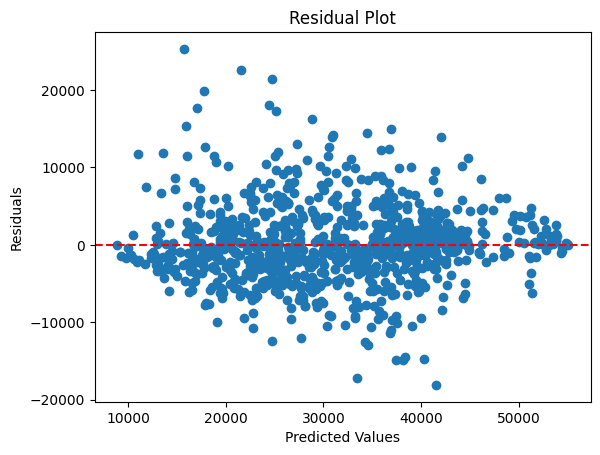

In [8]:

# Calculate residuals
residuals = y_test - y_pred

# Make the plot
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')  # horizontal line at 0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

#For the residuals, 482 are greater than 0 and 486 are less than 0


In [9]:
results['index'] = range(1, len(results) + 1) #creating index variable to access specific games
results[['index', 'abs_residual']]

#Games with the largest residuals: 
#302 165 448 84 270 38 186 413 379 557 489 565 667 221 521 8 349 729 967 395 661 27 512 577 963 453 262 373 818 29 695 567 88 372
#Games with the smallest residuals:
#69 354 156 432 388 421 401 195 49 647 309 880 402 31 847 556 801 371 436 761 835 357 216 76 269 18 599 873 962 235 501 863 772 189


,index,abs_residual
5072,1,6277.294589
487,2,382.387363
1155,3,5747.636458
6422,4,943.069203
5337,5,4997.861904
...,...,...
4598,964,3348.867421
2145,965,499.432315
1877,966,621.768772
7265,967,13971.309732


In [10]:

#Converting dummy variables back for easier analysis
one_hot_cols = [col for col in results.columns if col.startswith('cat__h_name_')]
results['h_name'] = results[one_hot_cols].idxmax(axis=1).str.replace('cat__h_name_', '', regex=False)

one_hot_cols_v = [col for col in results.columns if col.startswith('cat__v_name_')]
results['v_name'] = results[one_hot_cols_v].idxmax(axis=1).str.replace('cat__v_name_', '', regex=False)

one_hot_cols_week = [col for col in results.columns if col.startswith('cat__week_')]
results['week_number'] = results[one_hot_cols_week].idxmax(axis=1).str.replace('cat__week_', '', regex=False)


In [11]:
results_sub = results[['h_name','v_name','week_number','prev_year_wins','capacity','y_pred','y_test','abs_residual']]
results_sub

,h_name,v_name,week_number,prev_year_wins,capacity,y_pred,y_test,abs_residual
5072,TB,CLE,3,61.0,42735.0,19668.294589,13391.0,6277.294589
487,STL,LAD,5,105.0,50345.0,39366.387363,38984.0,382.387363
1155,MIA,ATL,11,83.0,47662.0,17399.363542,23147.0,5747.636458
6422,MIA,COL,16,78.0,47662.0,12499.069203,11556.0,943.069203
5337,DET,SEA,5,95.0,41083.0,32361.138096,37359.0,4997.861904
...,...,...,...,...,...,...,...,...
4598,CLE,MIN,21,93.0,43000.0,29124.132579,32473.0,3348.867421
2145,ARI,MIL,21,51.0,48686.0,23208.567685,23708.0,499.432315
1877,PIT,STL,19,72.0,38362.0,22127.768772,21506.0,621.768772
7265,LAD,SF,1,82.0,56000.0,42028.690268,56000.0,13971.309732


In [12]:
results_sub[results_sub['abs_residual'] > 5000]

,h_name,v_name,week_number,prev_year_wins,capacity,y_pred,y_test,abs_residual
5072,TB,CLE,3,61.0,42735.0,19668.294589,13391.0,6277.294589
1155,MIA,ATL,11,83.0,47662.0,17399.363542,23147.0,5747.636458
5857,OAK,STL,10,93.0,47170.0,26978.200603,35077.0,8098.799397
3616,SD,SF,12,82.0,42445.0,38372.983248,23888.0,14484.983248
2288,MIL,STL,22,67.0,41900.0,29923.263791,22472.0,7451.263791
...,...,...,...,...,...,...,...,...
4770,MIN,KC,23,83.0,55000.0,21892.134211,28540.0,6647.865789
239,SEA,CLE,3,63.0,47943.0,33241.633112,43207.0,9965.366888
4553,BAL,NYY,21,74.0,45971.0,34234.194932,21742.0,12492.194932
7265,LAD,SF,1,82.0,56000.0,42028.690268,56000.0,13971.309732


In [ ]:
home_counts = results_sub['h_name'].value_counts()
visitor_counts = results_sub['v_name'].value_counts()
home_counts, visitor_counts 
#Home: TB, OAK, LAA, PHI, LAD, SEA, WSH
#Away: NYM, MIN, CHC, TB, SD, CIN, LAD, COL, TEX

In [ ]:
#Dictionary showing the proportion of overestimates from the model (works with full results, not just largest residuals subset)
count_dict = {}
home_teams = results['h_name'].unique()

for team in home_teams:
    team_games = results[results['h_name'] == team]
    count_dict[team] = ((team_games['y_pred'] > team_games['y_test']).sum()) / np.float64((team_games['y_pred'] > team_games['y_test']).sum() + (team_games['y_pred'] < team_games['y_test']).sum())


count_df = pd.DataFrame(list(count_dict.items()), columns=['Home Team', 'Prop_OverEstimate'])
count_df['Prop_OverEstimate'] = count_df['Prop_OverEstimate'].round(3)
print(count_df)



   Home Team  Prop_OverEstimate
0         TB              0.595
1        STL              0.559
2        MIA              0.548
3        DET              0.613
4        OAK              0.659
5         SD              0.533
6        MIL              0.367
7        BOS              0.314
8        NYM              0.321
9        CIN              0.618
10       ARI              0.483
11       HOU              0.613
12       WSH              0.472
13       BAL              0.515
14       CHC              0.229
15       PHI              0.436
16       COL              0.706
17       TOR              0.625
18       LAD              0.342
19       NYY              0.333
20       CHW              0.591
21        SF              0.375
22       LAA              0.350
23       SEA              0.583
24       PIT              0.656
25       TEX              0.522
26        KC              0.500
27       MIN              0.593
28       ATL              0.444
29       CLE              0.625


In [ ]:
#within month (running average), proportion above/below actual
#temporal pattern 

#Residuals over time (color training residuals in one, test in another). dont do absolute value
#Then, could look at by team


#Average residual by team

In [ ]:
#Could add team payroll. With no salary cap, it could capture market size and player success (better players are likely to make more money)

In [15]:
# # Random Forest hyperparameter tuning
# # Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
# # Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10, 20],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)

In [16]:
# # Build random forest model - 21776 cases from 2005-2013
# modeldata = df_encoded[:21776]

# # Define features (X) and target variable (y)
# X = modeldata.drop(columns=['attendance'])
# y = modeldata['attendance']

# # Split data into training / test (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# # Initialize the Random Forest regressor
# model = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=5)

# # Set up K-Fold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Perform cross-validation and get the average score
# cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

# print("Cross-validation R-squared scores:", cv_scores)
# print("Mean CV R-squared:", cv_scores.mean())


# # # Fit the model
# # model.fit(X_train, y_train)

# # # Predict on the val set
# # y_pred = model.predict(X_test)

# # # Calculate Mean Squared Error (MSE) and R-squared score (R²)
# # mse = mean_squared_error(y_test, y_pred)
# # rmse = mse**(1/2)
# # r2 = r2_score(y_test, y_pred)

# # print(f'Mean Squared Error (MSE): {mse:.2f}')
# # print(f'RMSE: {rmse:.2f}')
# # print(f'R-squared Score (R²): {r2:.2f}')